In [1]:
## Most Important
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## less Important
from functools import partial
import os
from scipy import stats
import missingno as msno
import joblib
import tarfile
import shutil
import urllib

## Sklearn
from sklearn import datasets
## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
## Metrics
from sklearn.metrics import accuracy_score

## tensorflow & Keras
import tensorflow as tf    ## i will use tf for every thing and for keras using tf.keras
import tensorflow_datasets as tfds

## Custom Loss Functions
`I will build a custom huber function with diffrent thresholds`  <br />
`Passing this class or function to the loss hyperparameter when compiling the Model` <br />
`Saving the model, and when you loading it again, every thing is saved, this class or function is saved as json file in hdf5 model` <br />
`When loading the Model you should pass the dictionary of custom objects (as you will see)`

In [2]:
## simple function ==> what i want to do
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    like_MSE = tf.square(error) / 2
    like_MAE = tf.abs(error) - 0.5
    
    ## when erroe is less than trheshold => then like_MSE, else like_MAE
    return tf.where(is_small_error, like_MSE, like_MAE)

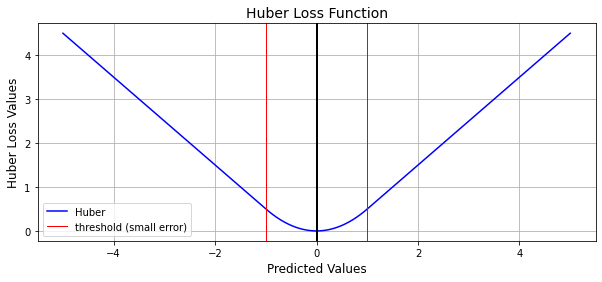

In [3]:
## plotting the huber_fn function
plt.figure(figsize=(10, 4))
pred_vals = np.linspace(-5, 5, 400)
losses = huber_fn(y_true=0, y_pred=pred_vals)
plt.plot(pred_vals, losses, 'b', label='Huber')
plt.axvline(-1, c='r', linewidth=1, label='threshold (small error)')
plt.axvline(1, c='r', linewidth=1)
plt.axvline(0, c='k', linewidth=2)
plt.title('Huber Loss Function', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Huber Loss Values', fontsize=12)
plt.grid()
plt.legend()
plt.show()   ## thresholds between -1, 1 ==> small error ==> squared MSE, else ==> linear MAE

In [4]:
## create a General Class, more flexiblity
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold, **kwargs):   ## **kwargs => to handle the main Hyperparameters
        self.threshold = threshold
        super().__init__(**kwargs)             ## inherit from the main class
    
    def call(self, y_true, y_pred):
        ''' this function is used instead of using MSE or MAE, it combine both of them
            when the loss is less than a specified threshold, it will be as MSE
            else when the loss is high than specified threshold, it will be as MAE
        '''
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        like_MSE = tf.square(error) / 2
        like_MAE = self.threshold * tf.abs(error) - self.threshold**2 / 2
        
        ## when erroe is less than trheshold => then like_MSE, else like_MAE
        return tf.where(is_small_error, like_MSE, like_MAE)

    def get_config(self):
        ''' this function is to save what model threshold is specified
        '''
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

`Now you can build your Model, compile it and pass the (HuberLoss) class to loss hyperparameter` <br />
`fit the Model and save it` <br />
`When you loading the Model again, you must specify a dictionary of custom_objects`

``` python
        ## when compiling the model, then fit it, then save it
        model.compile(loss=HuberLoss, optimizer='adam', metrics=['mae'])
        model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
        model.save('my_model_with_HuberLoss.h5')
        
        ## when loading the model again, you must specifiy as dictionary of custom objects
        my_model = tf.keras.models.load_model('my_model_with_HuberLoss.h5',
                                              custom_objects={'HuberLoss': HuberLoss})
```

`Now you can build your Model, compile it and pass the (HuberLoss) class to loss hyperparameter` <br />
`fit the Model and save it` <br />
`When you loading the Model again, you must specify a dictionary of custom_objects`

 python
        ## when compiling the model, then fit it, then save it
        model.compile(loss=HuberLoss, optimizer='adam', metrics=['mae'])
        model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
        model.save('my_model_with_HuberLoss.h5')
        
        ## when loading the model again, you must specifiy as dictionary of custom objects
        my_model = tf.keras.models.load_model('my_model_with_HuberLoss.h5',
                                              custom_objects={'HuberLoss': HuberLoss})

------

## Custom Activation Function, Initializers, Regularizers, and Constraints

#### `Custom soft_plus Activation Function`

$$f(x) = In(e^{x} + 1)$$

In [5]:
## for custom Activation function
## let's implement soft_plus Activation function
def my_softplus(x):
    ''' this Function is to create a custom Activation Function (soft_plus)
    '''
    soft_plus = tf.math.log(tf.math.exp(x) + 1.0)
    return soft_plus

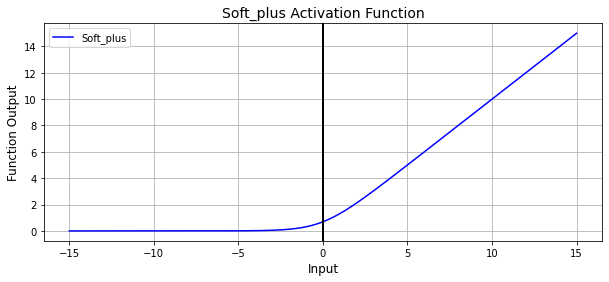

In [6]:
## Visulaizing soft_plus
plt.figure(figsize=(10, 4))
range_soft = np.linspace(-15, 15, 1000)
vals_soft = my_softplus(range_soft)
plt.plot(range_soft, vals_soft, 'b', label='Soft_plus')
plt.axvline(0, c='k', linewidth=2)
plt.title('Soft_plus Activation Function', fontsize=14)
plt.xlabel('Input', fontsize=12)
plt.ylabel('Function Output', fontsize=12)
plt.grid()
plt.legend()
plt.show()   

#### `Custom Intializers `
`glorot_normal ==> variance = (1 / fan_avg), mean = 0`

In [7]:
## make a custom glorot_normal intializer
def my_glorot_initializer(shape, dtype=tf.float32):
    ''' this Function tries to make weights intialization with glorot_normal Method
        take the shape (fan_in, fan_out)
    '''
    std_dev = tf.sqrt(2.0 / (shape[0] + shape[1]))
    weights_glorot = tf.random.normal(shape, mean=0, stddev=std_dev)
    return weights_glorot

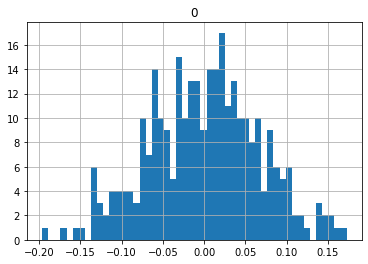

In [8]:
## test this function distribution
weights_glorot = my_glorot_initializer((300, 100), dtype=tf.float32)
pd.DataFrame(weights_glorot[:,0]).hist(bins=50);  ## test one faeture ==> Normal Dist. ==> ok!

#### `L1 regularizer `

In [9]:
## define custom function implemetns l1_regularizer, adding loss (alpha * abs(weights) + loss)
## np.sum() => tf.reduce_sum()
def my_l1_regularizer(weights):
    ''' this Function tries to add loss to the Main Loss function => (alpha * weights)
            let alpha=0.01
    '''
    new_loss = tf.reduce_sum(tf.abs(weights) * 0.01)
    return new_loss

#### `Positive Constraint for weights `

In [10]:
## define custom function to make constraints for returning only postive weights
def my_postive_weights(weights):
    ''' this Function tries to return only postive weights
    '''
    postive_only_else_zero = tf.where(weights < 0, tf.zeros_like(weights), weights)
    return postive_only_else_zero

`Now you can build your Model, pass these Function to the Model, compiling, fitting and saving the Model, but also when you load the Model again, you should specify custom_objects dictionary`

``` python
        ## when building the Model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(30, activation=my_softplus,  ## custom activation
                         kernel_initializer=my_glorot_initializer,   ## custom initializer
                         kernel_regularizer=my_l1_regularizer,  ## custom regularizer
                         kernel_constraint=my_postive_weights)) ## custom constraint
        model.compile(____)
        model.fit(____)
        model.save('my_model_with_customs.h5')
                   
        ## when loading the Model
        my_model = tf.keras.models.load_model('my_model_with_customs.h5',
                              custom_objects={'soft_plus':my_softplus,
                                              'my_glorot_initializer': my_glorot_initializer,
                                              'my_l1_regularizer' : my_l1_regularizer,
                                              'my_postive_weights': my_postive_weights})
        

```

## Computing Gradients using autodiff
`using reverse-mode autodiff`

$$f(x) = 3 * w_1^{2} + 2 * w_1 * w_2$$

In [11]:
## define the function contains the equation
def f(w1, w2):
    return 3 * w1**2 + 2 * w1 * w2

w1, w2 = tf.Variable(5.), tf.Variable(3.)
## when (w1, w2) = (5, 3)
## partial_derivative regard to w1 ==> 36
## partial_derivative regard to w1 ==> 10
## Jacobian vector = [36, 10]

## using GradientTape
## persistent=True  ==> to be able to call it more times without raising errors
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

jacob_vector = tape.gradient(z, [w1, w2])
jacob_vector ### [36., 10] ===> it is True ==> magic!

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

## Done !